# Contributing to EUREC⁴A-MIP

To ease the comparison of the individual contributions and make the contributions accessible among collaborators and the broader audience, the simulation output from the EUREC⁴A-Model intercomparison will be made available on the DKRZ SWIFT storage. To use this storage efficiently and embed it within the analysis workflow the output needs to be prepared.

## Overview

- Creation of dataset
    - merge output into reasonable pieces (concat along time dimension)
    - add attributes as necessary to describe variables
    - ensure CF-conform time variable
    - remove duplicate entries
- Generation of zarr files:
    - resonable chunks (depending on typical access pattern)
    - resonable chunk size (about 10MB)
    - usage of `/` as `dimension_separator`
- Upload files:
    - either write zarr-files directly to swift-storage at DKRZ
    - or create the zarr-files locally and upload them afterwards to the swift-storage
    - or create tar-files, transfer to DKRZ disk space and then upload to the swift-storage

## Creation
The structure of zarr-files is fairly simple ([specifications](https://zarr.readthedocs.io/en/stable/spec/v2.html)) and can, in general, be created with any software. The easiest way to create zarr files is, however, in the python environment, especially with the xarray package:
```python
import xarray as xr
ds = xr.open_mfdataset("output_*.nc")
ds.to_zarr("output.zarr")
```
A few things should be noted to create performant datasets:
- **resonable chunks (depending on typical access pattern)**
  - the shape of the chunks i.e. how the data is split in time and space should allow for reasonable performance for all typical access patterns. To do so, the chunks should contain data along all directions, especially along space and time to enable both fast analysis of temporal timeseries at a single point in space as well as plotting the entire domain as once at a particular time.
- **resonable chunk size (about 10MB)**
    - the size of the individual chunks should be about 10MB. This is a good size to make requests over the internet efficient. Decisive is the size of the compressed chunks and not the size after decompression. 
- **usage of `/` as `dimension_delimiter`**
  - Zarr files following version spec 1 and 2 are generally containing one subfolder per variable that contain all chunks of that variable. To reduce the pressure on the filesystem, the `dimension_delimter="/"` creates more subfolders such that each folder indexes only a fraction of all files. 

- **merge output into reasonable pieces (concat along time dimension)**
  
  Because the zarr-files are chunked and only those portions are loaded into memory that are actually needed at the time of calculation, huge datasets can be created without loosing performance. The user benefits from this approach because with a single load statement a lot of datasets are available. For the proposed output variables, this means, that for each category ("2D Surface and TOA", "2D Integrated Variables", "2D fields at specified levels", "3D fields") only one dataset (zarr-file) should be created.
  If the temporal or spatial resolution differs for some variables, these variables should be written to an additional dataset. It should be avoided to have two time/height coordinates per dataset (i.e. there should only be one time coordinate `time` and no `time2`)
  
  A dataset should always contain all timesteps from the beginning of the simulation until its end.
- **rename the variable names to the ones given in the specific documents ([LES](https://eurec4a.eu/fileadmin/user_upload/eurec4a/Simulations/EUREC4A_LEM_Model_Output.pdf), [SRM](https://eurec4a.eu/fileadmin/user_upload/eurec4a/Simulations/EUREC4A_SRM_Model_Output.pdf))**
  
  Having consistent variable names across models significantly increases the user experience when analysing and comparing the output
  ```python
  ds = ds.rename({"model_var1":"eurec4amip_var1", "model_var2":"eurec4amip_var2"})
  ```
- **add attributes as necessary to describe variables**
  ```python
  ds.u10.attrs["standard_name"] = "eastward_wind"
  ds.u10.attrs["units"] = "ms-1"
  ```
- **ensure CF-conform time variable**
    The time unit should be CF-conform such that it is easily understood by common tools. In particular, the following should work:
    ```python
    ds.sel(time=slice("2020-01-20 00:00:00", "2020-02-01 00:00:00"))
    ```
- **remove duplicate entries**
  Please check the output for any duplicate timesteps and check that the time is monotonic increasing
  ```python
  ds = ds.drop_duplicates(dim="time")
  ```

## Upload
zarr-files are great to upload to object stores like the swift-storage at DKRZ or Azure Blobs, Google Buckets and Amazon S3. Due to their structure, every single chunk is saved as a separate object. On a file storage system, currently the standard on HPC systems for climate simulations, these chunks are the individual files within a zarr directory:

```
tree eraint_uvz.zarr/
eraint_uvz.zarr/
|-- latitude
|   `-- 0
|-- level
|   `-- 0
|-- longitude
|   `-- 0
|-- month
|   `-- 0
|-- u
|   |-- 0
|   |   |-- 0
|   |   |   |-- 0
|   |   |   |   `-- 0
|   |   |   `-- 1
|   |   |       `-- 0
|   |   `-- 1
|   |       |-- 0
|   |       |   `-- 0
|   |       `-- 1
|   |           `-- 0
|   `-- 1
|       |-- 0
```
These can be directly written to the DKRZ swift-storage during creation (1), after creating the file locally (2) or transferred to the DKRZ’s file storage on traditional ways via ssh or ftp (3) from where they need to be uploaded via (2) to the SWIFT storage.

1. **Writing directly to the swift-storage**
	```python
	import zarr
	import xarray as xr

	async def get_client(**kwargs):
	 import aiohttp
	 import aiohttp_retry
	 retry_options = aiohttp_retry.ExponentialRetry(
		 attempts=3,
		 exceptions={OSError, aiohttp.ServerDisconnectedError})
	 retry_client = aiohttp_retry.RetryClient(raise_for_status=False, retry_options=retry_options)
	 return retry_client
	 
	ds = xr.tutorial.load_dataset("eraint_uvz")  # This is just an example dataset
	store = zarr.storage.FSStore("output.zarr", get_client=get_client, dimension_separator="/")
	ds.to_zarr(store)
	```

2. **Writing the zarr file locally and upload after creation**	
	
	2.1 **Writing dataset to disk**

	```python
	import zarr
	import xarray as xr

	ds = xr.tutorial.load_dataset("eraint_uvz")  # This is just an example dataset
	store = zarr.DirectoryStore("output.zarr", dimension_separator="/")
	ds.to_zarr(store)
	```
	
	2.2 **Uploading file to the DKRZ SWIFT storage**
		
	The upload can be performed with [python-swiftclient](https://platform.swiftstack.com/docs/integration/python-swiftclient.html) which can be installed via `pip install python-swiftclient`.

	To upload the zarr file to swift, an access token needs to be generated first, with
	
	```
	curl -I -X GET https://swift.dkrz.de/auth/v1.0 -H "x-auth-user: <GROUP>:<USERNAME>" -H "x-auth-key: <PASSWORD>" > ~./swiftenv
	```

	where group is `bm1349` for EUREC4A-MIP.
		       
	The token has to be activated with the following command each time a new terminal has been opened:
	
	```
	source ~/.swiftenv
	```
	
	Please contact [Hauke Schulz](mailto:haschulz@uw.edu) if you don't have a DKRZ account and otherwise let him know about your username so that it can be added to the project.
		       
	The upload itself is performed by
	
	```
	swift upload -c <CONTAINER> <FILENAME>
	```
	
	where `<CONTAINER>` should be set with a meaningful name describing the dataset `<FILENAME>`. Examples are `ICON_LES_control_312m`, `HARMONIE_SRM_warming_624m` or in general following the schema `<model>_<setup>_<experiment>_<resolution>`. The filename can follow the same principle and just add `_<subset>` e.g. `ICON_LES_control_312m_3D` or `HARMONIE_SRM_warming_624m_2D`. In general, the container and filenames are not of importance because the files will be referenced through the [EUREC4A intake catalog](https://github.com/eurec4a/eurec4a-intake) where they will get a meaningful name. Nevertheless, for users who want to download the datasets themselves a bit of structure is nice.

	```{note}
	Please create a new container for each larger dataset (large meaning many files (>1000)). This makes it much easier to delete false datasets, because containers can be much more effeciently deleted on the object store than individual files.
	```

3. **Creating zarr files locally and transfer them to DKRZ’s filestore via ssh/ftp**

	To transfer zarr files via ftp or ssh, it is advisable to pack zarr files into larger quantities of several GB.
	If a single tar would be too large and the content shall be distributed across several tar files, it is beneficial to create tar files that are closed in itself, i.e. the data is not split mid-record. This step is needed to allow opening tar-ed zarr files directly without the need of unpacking them.
	
	- [Tool to split tar files at file boundaries](https://github.com/monoid/splitar)
	- [Further information on how to access tared zarr files](https://github.com/observingClouds/tar_referencer)
	
	```{note}
	Compression via zip/gzip is not needed and should be avoided. The data in the zarr files is already compressed and additional compression is not expected to reduce the data amount significantly.
	```

## Indexing
After the upload has been finished the output needs to be added to the [EUREC⁴A-Intake catalog](https://github.com/eurec4a/eurec4a-intake). Please open a Pull Request and follow the [contribution guidelines](https://github.com/eurec4a/eurec4a-intake/blob/master/CONTRIBUTING.md). The maintainers will help with this process if needed.

Optionally, some description about the specific model run can be added to this webpage by opening a [Pull Request](https://github.com/eurec4a/how_to_eurec4a/pulls).

# Accessing the simulations
The project is on-going and so far no contributions have been made available. The documentation of the {doc}`icon_les` and {doc}`botany_dales` simulations made apart from this intercomparison project give already a taste on how the access will be possible.

The EUREC⁴A-MIP output should be available in a similar matter and further combined by a datatree object.

In [1]:
import datatree
import dask.array as da
import xarray as xr
import numpy as np
import pandas as pd
def r():
    return np.random.random(1).item(0)

times = pd.date_range('2020-01-01', '2020-03-01', freq='10T')
heights = np.arange(0,10000,200)
pseudo_ds = xr.Dataset({'t':(('time','height','cell'), da.random.random((len(times),len(heights), 5000))),
                        'u':(('time','height','cell'), da.random.random((len(times),len(heights), 5000))*5)},
                       coords={'time':times, 'height':heights}
                      )
pseudo_ds.height.attrs['units']:'meter'
pseudo_ds.t.attrs['units']:'K'
pseudo_ds.u.attrs['units']:'m/s'
pseudo_ds_2D = pseudo_ds.isel(height=0).squeeze(drop=True).drop("height").rename({'t':'t_2m','u':'u_10m'})

pseudo_tree = {'control':{'LES':{'DALES':{'3D':pseudo_ds,'2D':pseudo_ds_2D*r()},
                                               'ICON':{'3D':pseudo_ds,'2D':pseudo_ds_2D*r()}},
                          'SRM':{'DALES':{'3D':pseudo_ds,'2D':pseudo_ds_2D*r()},
                                               'ICON':{'3D':pseudo_ds.isel(time=slice(0,200),height=slice(0,None,3)),
                                                       '2D':pseudo_ds_2D.isel(time=slice(0,200))*r()},
                                               'HARMONIE':{'3D':pseudo_ds.isel(time=slice(0,200)),
                                                           '2D':pseudo_ds_2D.isel(time=slice(0,200))*r()},
                                               'AROME':{'3D':pseudo_ds.isel(time=slice(0,100)),
                                                        '2D':pseudo_ds_2D.isel(time=slice(0,100))*r()}
                                       }},
               'warming':{'LES':{'DALES':{'3D':pseudo_ds,'2D':pseudo_ds_2D*r()},
                                 'ICON':{'3D':pseudo_ds,'2D':pseudo_ds_2D*r()}
                                },
                          'SRM':{'DALES':{'3D':pseudo_ds,'2D':pseudo_ds_2D*r()},
                                 'HARMONIE':{'3D':pseudo_ds.isel(time=slice(0,200)),
                                             '2D':pseudo_ds_2D.isel(time=slice(0,200))*r()}
                                }},
              }

df = pd.json_normalize(pseudo_tree, sep='/')
pseudo_tree_flat = df.to_dict(orient='records')[0]

/tmp/ipykernel_3077/2125096091.py:9: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  times = pd.date_range('2020-01-01', '2020-03-01', freq='10T')
/tmp/ipykernel_3077/2125096091.py:18: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  pseudo_ds_2D = pseudo_ds.isel(height=0).squeeze(drop=True).drop("height").rename({'t':'t_2m','u':'u_10m'})


## Datatree object
A datatree object can group several datasets into one larger object. It allows to apply operators on all datasets within such an object even in cases where the size of dimensions e.g. due to different resolutions do not agree. A [blogpost](https://medium.com/pangeo/easy-ipcc-part-1-multi-model-datatree-469b87cf9114) from the developers shows the potential of these objects for simulation ensembles and their intercomparison. For EUREC⁴A-MIP the datatree could look as follows:

In [2]:
dt = datatree.DataTree.from_dict(pseudo_tree_flat)
dt

DataTree('None', parent=None)
├── DataTree('control')
│   ├── DataTree('LES')
│   │   ├── DataTree('DALES')
│   │   │   ├── DataTree('3D')
│   │   │   │       Dimensions:  (time: 8641, height: 50, cell: 5000)
│   │   │   │       Coordinates:
│   │   │   │         * time     (time) datetime64[ns] 69kB 2020-01-01 ... 2020-03-01
│   │   │   │         * height   (height) int64 400B 0 200 400 600 800 ... 9000 9200 9400 9600 9800
│   │   │   │       Dimensions without coordinates: cell
│   │   │   │       Data variables:
│   │   │   │           t        (time, height, cell) float64 17GB dask.array<chunksize=(579, 50, 579), meta=np.ndarray>
│   │   │   │           u        (time, height, cell) float64 17GB dask.array<chunksize=(579, 50, 579), meta=np.ndarray>
│   │   │   └── DataTree('2D')
│   │   │           Dimensions:  (time: 8641, cell: 5000)
│   │   │           Coordinates:
│   │   │             * time     (time) datetime64[ns] 69kB 2020-01-01 ... 2020-03-01
│   │   │           Dimensions without coordinates: cell
│   │   │           Data variables:
│   │   │               t_2m     (time, cell) float64 346MB dask.array<chunksize=(579, 579), meta=np.ndarray>
│   │   │               u_10m    (time, cell) float64 346MB dask.array<chunksize=(579, 579), meta=np.ndarray>
│   │   └── DataTree('ICON')
│   │       ├── DataTree('3D')
│   │       │       Dimensions:  (time: 8641, height: 50, cell: 5000)
│   │       │       Coordinates:
│   │       │         * time     (time) datetime64[ns] 69kB 2020-01-01 ... 2020-03-01
│   │       │         * height   (height) int64 400B 0 200 400 600 800 ... 9000 9200 9400 9600 9800
│   │       │       Dimensions without coordinates: cell
│   │       │       Data variables:
│   │       │           t        (time, height, cell) float64 17GB dask.array<chunksize=(579, 50, 579), meta=np.ndarray>
│   │       │           u        (time, height, cell) float64 17GB dask.array<chunksize=(579, 50, 579), meta=np.ndarray>
│   │       └── DataTree('2D')
│   │               Dimensions:  (time: 8641, cell: 5000)
│   │               Coordinates:
│   │                 * time     (time) datetime64[ns] 69kB 2020-01-01 ... 2020-03-01
│   │               Dimensions without coordinates: cell
│   │               Data variables:
│   │                   t_2m     (time, cell) float64 346MB dask.array<chunksize=(579, 579), meta=np.ndarray>
│   │                   u_10m    (time, cell) float64 346MB dask.array<chunksize=(579, 579), meta=np.ndarray>
│   └── DataTree('SRM')
│       ├── DataTree('DALES')
│       │   ├── DataTree('3D')
│       │   │       Dimensions:  (time: 8641, height: 50, cell: 5000)
│       │   │       Coordinates:
│       │   │         * time     (time) datetime64[ns] 69kB 2020-01-01 ... 2020-03-01
│       │   │         * height   (height) int64 400B 0 200 400 600 800 ... 9000 9200 9400 9600 9800
│       │   │       Dimensions without coordinates: cell
│       │   │       Data variables:
│       │   │           t        (time, height, cell) float64 17GB dask.array<chunksize=(579, 50, 579), meta=np.ndarray>
│       │   │           u        (time, height, cell) float64 17GB dask.array<chunksize=(579, 50, 579), meta=np.ndarray>
│       │   └── DataTree('2D')
│       │           Dimensions:  (time: 8641, cell: 5000)
│       │           Coordinates:
│       │             * time     (time) datetime64[ns] 69kB 2020-01-01 ... 2020-03-01
│       │           Dimensions without coordinates: cell
│       │           Data variables:
│       │               t_2m     (time, cell) float64 346MB dask.array<chunksize=(579, 579), meta=np.ndarray>
│       │               u_10m    (time, cell) float64 346MB dask.array<chunksize=(579, 579), meta=np.ndarray>
│       ├── DataTree('ICON')
│       │   ├── DataTree('3D')
│       │   │       Dimensions:  (time: 200, height: 17, cell: 5000)
│       │   │       Coordinates:
│       │   │         * time     (time) datetime64[ns] 2kB 2020-01-01 ... 2020-01-02T09:10:00
│       │   │         * h

(this is artificial data)

The data can be analysed and visualized without looping over each dataset individually but rather by applying a single function to the entire ensemble at once:

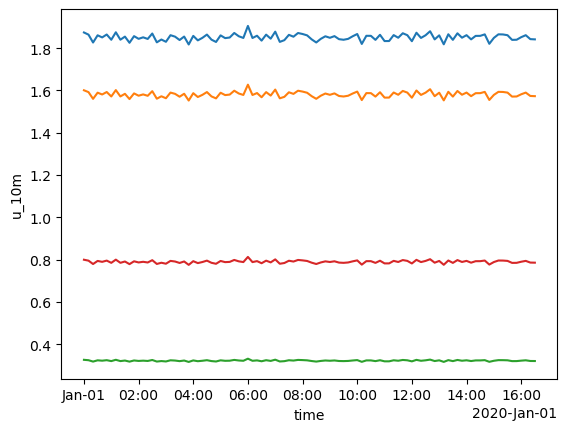

In [3]:
import matplotlib.pyplot as plt
from datatree import map_over_subtree
fig, ax = plt.subplots()

@map_over_subtree
def plot_temp(ds): 
    if ds:
        if 'u_10m' in ds.data_vars:
            ds['u_10m'].isel(time=slice(0,100)).mean('cell').plot(ax=ax)
    return ds
_ = plot_temp(dt['warming'])

## Additional support

In case the analysis tools are not written in Python or do not support zarr files yet, files can be downloaded and read with newer version of the netCDF library. This is however not recommended because it makes the analysis much more complicated and downloads potentially unnessary data. Nevertheless, an example is presented in the following. Here we make use of the new netCDF-c library that now not only supports HDF5 as an backend, but also Zarr. These so called NCZarr files can be created on-the-fly by the netCDF-c libary from a zarr file.

### Download entire datasets
```bash
wget -r -H -N --cut-dirs=5 --include-directories="/v1/" "https://swiftbrowser.dkrz.de/public/dkrz_948e7d4bbfbb445fbff5315fc433e36a/EUREC4A_LES/experiment_2/EUREC4A_ICON-LES_control_DOM03_surface_native.zarr?show_all"
```
The exact link to the dataset in question can be found in the EUREC4A-Intake catalog or potentially explored at `https://swiftbrowser.dkrz.de/public/dkrz_0913c8f3-e7b6-4f94-9221-06880d4ccfea/<model>`

### Download subsets of datasets
Because each data chunk of a Zarr file is an individual object on the SWIFT object store, each variable of a dataset can be downloaded separately:
```bash
# Download variable of interest (here t_2m)
wget -r -H -N --cut-dirs=5 --include-directories="/v1/" "https://swiftbrowser.dkrz.de/public/dkrz_948e7d4bbfbb445fbff5315fc433e36a/EUREC4A_LES/experiment_2/EUREC4A_ICON-LES_control_DOM03_surface_native.zarr/t_2m?show_all"
```
To preserve the coordinates and metadata, the objects containing this information need to be downloaded as well:
```bash
# Download metadata
wget -r -H -N --cut-dirs=5 --include-directories="/v1/" "https://swiftbrowser.dkrz.de/public/dkrz_948e7d4bbfbb445fbff5315fc433e36a/EUREC4A_LES/experiment_2/EUREC4A_ICON-LES_control_DOM03_surface_native.zarr/.zmetadata?show_all"
# Download coordinates 
wget -r -H -N --cut-dirs=5 --include-directories="/v1/" "https://swiftbrowser.dkrz.de/public/dkrz_948e7d4bbfbb445fbff5315fc433e36a/EUREC4A_LES/experiment_2/EUREC4A_ICON-LES_control_DOM03_surface_native.zarr/time?show_all"
```

### Working with the downloaded datasets
In case the analysis software in question cannot open zarr files but only netCDF files, then the Zarr files can be opened with the syntax `"file://<absolute_path>/<file.zarr>#mode=nczarr,file"`. `#mode=nczarr,file` is telling the netCDF library that the given path shall be interpreted as a NCZarr file. More information about this feature can be found on the [Unidata webpage](https://www.unidata.ucar.edu/blogs/developer/en/entry/nczarr-support-for-zarr-filters)

In the particular case of the downloaded dataset from above, this could look like the following to investigate the dataset
```bash
ncdump -h "file:///<absolute_path_to_current_directory>/swift.dkrz.de#mode=nczarr,file"
```
with a slightly older version of the netCDF-c library:
```bash
ncdump -h "file:///<absolute_path_to_current_directory>/swift.dkrz.de#mode=nczarr,xarray"
```

or when post-processing the output with CDO from the command line:
```bash
cdo -selname,t_2m -seltimestep,1/5 -timavg "file:///<absolute_path_to_current_directory>/swift.dkrz.de#mode=nczarr,file" result.nc
```

```{note}
For this feature to work, the tools (e.g. ncdump, cdo, etc.) need to be linked to a current version of the netCDF-c library (at least 4.8.0).
```